### Import

In [1]:
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison

## Display function

In [2]:
#function for displaying ROC curves of multiple classifiers

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def plot_roc_connected_points(results_list, results_original_roc, name="All Classifiers"):
    """
    Creates a plot showing the performance of all classifiers as points,
    and connects them with a line, sorted by FPR.

    Args:
        results_list: A list of dictionaries, where each dict contains 'fpr', 'tpr'.
    """
    if not results_list:
        print("No results to plot.")
        return

    # Convert results to a pandas DataFrame for easy sorting
    df = pd.DataFrame(results_list)
    
    # Sort the models by their False Positive Rate to create a left-to-right line
    df_sorted = df.sort_values(by=['fpr','tpr']).reset_index(drop=True)
    
    # --- Plotting ---
    plt.figure(figsize=(10, 10))
    
    # Plot all the individual model points as a scatter plot
    # This helps see the actual performance of each model
    plt.scatter(df_sorted['fpr'], df_sorted['tpr'], c='black', marker='o', 
                alpha=0.6, s=100, zorder=3) # zorder=3 puts dots on top

    # Plot the line connecting the points
    plt.plot(df_sorted['fpr'], df_sorted['tpr'], color='red', lw=1.5,
             alpha=0.8, label=f'{name} (AUC = {auc(df_sorted["fpr"], df_sorted["tpr"]):.2f})')
    
    #plot the original ROC curve
    plt.plot(results_original_roc["fpr"], results_original_roc["tpr"], color='blue', 
             label=f'{results_original_roc["name"]} (AUC = {results_original_roc["auc"]:.2f})')

    # Plot the "no-skill" line for reference
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate (FPR)')
    plt.ylabel('True Positive Rate (TPR)')
    plt.title('Performance Path of All Trained Classifiers')
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

## Best ROC envelope

In [3]:
import numpy as np
from sklearn.metrics import roc_curve

def get_best_roc_envelope(results_list, results_original_roc=None):
    """
    Constructs the upper envelope of multiple ROC curves to find the best
    possible operating points from a collection of classifiers.

    This function is guaranteed to produce a list of points that starts at
    (FPR=0, TPR=0) and ends at (FPR=1, TPR=1), making it suitable for direct
    plotting and AUC calculation.

    Args:
        results_list (list): A list of dictionaries. Each dictionary must
                             contain a 'model' name and the full ROC results
                             under the 'full_roc' key.
        results_original_roc (dict, optional): A dictionary containing the
                                               ROC results of a baseline model,
                                               which will also be included in
                                               the comparison. Defaults to None.

    Returns:
        list: A sorted list of dictionaries representing the optimal ROC
              envelope. Each dictionary includes 'model', 'fpr', 'tpr',
              and 'threshold'.
    """
    all_points = []

    # Step 1: Gather all ROC points from all provided models
    all_results = results_list[:]
    if results_original_roc:
        all_results.append({
            'model': 'original_baseline',
            'full_roc': results_original_roc
        })

    for result in all_results:
        model_name = result.get('model', 'Unknown Model')
        roc = result.get('full_roc')
        if not roc: continue

        fprs = roc.get('fpr', [])
        tprs = roc.get('tpr', [])
        thresholds = roc.get('thresholds', [])

        for i in range(len(fprs)):
            threshold = thresholds[i] if i < len(thresholds) else thresholds[-1]
            all_points.append({
                'model': model_name, 'fpr': fprs[i],
                'tpr': tprs[i], 'threshold': threshold
            })

    # Handle case with no data by returning a default diagonal line
    if not all_points:
        return [
            {'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf},
            {'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0}
        ]

    # Step 2: Sort all points by FPR (asc), then by TPR (desc)
    all_points.sort(key=lambda p: (p['fpr'], -p['tpr']))

    # Step 3: Build the core ROC envelope
    best_roc_envelope = []
    max_tpr_so_far = -1.0
    for point in all_points:
        # Add a point only if it has a strictly higher TPR
        if point['tpr'] > max_tpr_so_far:
            # To prevent adding multiple points at the same FPR, check if the last point
            # has the same FPR and replace it if so (since this one has a higher TPR)
            if best_roc_envelope and best_roc_envelope[-1]['fpr'] == point['fpr']:
                best_roc_envelope[-1] = point
            else:
                best_roc_envelope.append(point)
            max_tpr_so_far = point['tpr']
    
    # Step 4: Manually add extremities if they are missing
    
    # Ensure the curve starts at (0, 0)
    if not best_roc_envelope or best_roc_envelope[0]['fpr'] > 0.0:
        best_roc_envelope.insert(0, {
            'model': 'start', 'fpr': 0.0, 'tpr': 0.0, 'threshold': np.inf
        })

    # Ensure the curve ends at (1, 1)
    if best_roc_envelope[-1]['fpr'] < 1.0 or best_roc_envelope[-1]['tpr'] < 1.0:
        best_roc_envelope.append({
            'model': 'end', 'fpr': 1.0, 'tpr': 1.0, 'threshold': 0.0
        })

    return best_roc_envelope

## Data generation

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sympy import re

def generate_data(dataset):
    if dataset == "data1":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [0, 2], [2, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )

        

        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")
    elif dataset == "data2":
        no_predictors = 2
        no_samples = 1600
        no_classes = 2
        #kerneltype = 'linear'  #comment out for polynomial kernel
        #kerneltype = 'poly'  #comment out for linear kernel



        n_samples_per_cluster = 400
        n_clusters = 4

        # Create the clusters deterministically
        np.random.seed(0) # for reproducibility

        X = np.zeros((n_samples_per_cluster * n_clusters, 2))
        y = np.zeros(n_samples_per_cluster * n_clusters)

        # Cluster centers in corners of a square
        centers = [[0, 0], [2, 0], [1, 2], [1, 2]]

        # Assign points to clusters deterministically
        for i in range(n_clusters):
            cluster_indices = slice(i * n_samples_per_cluster, (i + 1) * n_samples_per_cluster)
            X[cluster_indices] = centers[i] + np.random.normal(scale=0.5, size=(n_samples_per_cluster, 2))
            if i == 0 or i == 3:
                y[cluster_indices] = 0
            else:
                y[cluster_indices] = 1



        #Visualize
        plt.figure(figsize=(8,8))
        plt.scatter(X[:,0], X[:,1], c=y, cmap='viridis', s=50)
        plt.title('Four Clusters of Equal Size')
        plt.xlabel('Feature 1')
        plt.ylabel('Feature 2')
        plt.show()

        #add intercept to X
        #X = np.hstack((np.ones((X.shape[0], 1)), X))

        # # shuffle data
        # permutation = np.random.permutation(no_samples)
        # X = X[permutation]
        # y = y[permutation]


        #Split data into training and testing sets
        # Step 1: Split off the 1000 training samples. The rest (600) go into a temporary pool.
        # We can use absolute numbers for the size.
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=1000,  # Specify exactly 1000 samples for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )


        train_data = np.concatenate((X_train, y_train.reshape(-1, 1)), axis=1)
        test_data = np.concatenate((X_test, y_test.reshape(-1, 1)), axis=1)

        val_data = test_data

        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

    elif dataset == "pneumoniaMNIST":
        import medmnist
        print(medmnist.__version__)
        # read in the PneumoniaMNIST dataset
        from medmnist import PneumoniaMNIST
        train_data = PneumoniaMNIST(split='train', download=True, size=224)
        test_data = PneumoniaMNIST(split='test', download=True, size=224)
        val_data = PneumoniaMNIST(split='val', download=True, size=224)
        # print the dataset info
        print(f"Number of training samples: {len(train_data)}")
        print(f"Number of test samples: {len(test_data)}")
        print(f"Number of validation samples: {len(val_data)}")

    elif dataset == "sonar":
        from ucimlrepo import fetch_ucirepo
        from sklearn.compose import ColumnTransformer
        from sklearn.pipeline import Pipeline
        from sklearn.impute import SimpleImputer
        from sklearn.preprocessing import LabelEncoder, StandardScaler, OneHotEncoder
        from sklearn.model_selection import train_test_split
        import re
  
        # fetch dataset 
        sonar = fetch_ucirepo(id=151) 
        
        # data (as pandas dataframes) 
        X_df = sonar.data.features 
        y_df = sonar.data.targets 

        X = X_df.to_numpy()
        y = y_df.to_numpy()

       
        # . Encode the target variable
        y = LabelEncoder().fit_transform(y)

        
        # Split data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(
            X, y,
            train_size=0.7,  # 70% for training
            random_state=42,
            stratify=y        # Crucial for classification: keeps class proportions the same
        )
        print(f"Training data shape: {X_train.shape}, {y_train.shape}")
        print(f"Test data shape: {X_test.shape}, {y_test.shape}")

        y_train = y_train.reshape(-1, 1) if len(y_train.shape) == 1 else y_train
        y_test = y_test.reshape(-1, 1) if len(y_test.shape) == 1 else y_test

        print(f"X_train type: {type(X_train)}, ndim: {X_train.ndim}, shape: {X_train.shape}")
        print(f"y_train type: {type(y_train)}, ndim: {y_train.ndim}, shape: {y_train.shape}")
        # 9. Concatenate the data
        train_data = np.concatenate((X_train, y_train), axis=1)
        test_data = np.concatenate((X_test, y_test), axis=1)
        val_data = test_data  # For simplicity, using test data as validation data

        print(f"Shape of training data: {train_data.shape}")
        print(f"Shape of test data: {test_data.shape}")

        print("\nData successfully processed and concatenated.")
        print(f"Shape of final training data: {train_data.shape}")


    return train_data, test_data, val_data


## Calculate Statistics function

In [5]:
import numpy as np
from sklearn.metrics import confusion_matrix

def get_fpr_tpr(clf_model, X_test, y_test, threshold=0.5):
    """
    Calculates the False Positive Rate (FPR) and True Positive Rate (TPR) at a given threshold.

    Args:
        X_test: The test features.
        y_test: The true test labels (0 or 1).
        threshold: The probability threshold.

    Returns:
        A dictionary containing the FPR and TPR. Returns None if there's an error.
    """
    try:
        y_prob = clf_model.predict_proba(X_test)[:, 1]
        y_pred = (y_prob >= threshold).astype(int)

        tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0  #Avoid division by zero
        tpr = tp / (tp + fn) if (tp + fn) > 0 else 0 #Avoid division by zero
        precision = tp / (tp + fp) if (tp + fp) > 0 else 0
        recall = tp / (tp + fn) if (tp + fn) > 0 else 0
        f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0
        accuracy = (tp + tn) / (tp + tn + fp + fn)
        misclassification_rate = 1 - accuracy

        return {"fpr": fpr, "tpr": tpr, "precision": precision, "recall": recall, "f1": f1, "accuracy": accuracy, "misclassification_rate": misclassification_rate}

    except ValueError as e:
        print(f"Error calculating FPR and TPR: {e}")
        return None





In [6]:
# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4
K_FOLDS = 4

## Sonar: NN

In [7]:
from sklearn.model_selection import KFold
import torch
import torch.utils.data as data

train_data, test_data, val_data = generate_data("sonar")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

# initialize fold
kfold = KFold(n_splits=K_FOLDS, shuffle=True, random_state=42)





Training data shape: (145, 60), (145,)
Test data shape: (63, 60), (63,)
X_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (145, 60)
y_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (145, 1)
Shape of training data: (145, 61)
Shape of test data: (63, 61)

Data successfully processed and concatenated.
Shape of final training data: (145, 61)


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


### Neural Network

In [8]:
import torch
import torch.nn as nn
import torch.optim as optim
import pytorch_lightning as pl
import torchmetrics
import numpy as np

In [9]:
class MLP(nn.Module):
    def __init__(self, input_features=14, hidden_units=16, num_classes=1):
        super(MLP, self).__init__()

        self.network = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units//2),
            nn.ReLU(),
            nn.Linear(hidden_units//2, num_classes),
        )

    def forward(self, x):
        return self.network(x)
    
# A new LightningModule just for training the classifier
class LitClassifier(pl.LightningModule):
    def __init__(self, input_features=14, hidden_units=16, num_classes=1, learning_rate=1e-4, pos_weight=None):
        super().__init__()
        self.save_hyperparameters()
        self.model = MLP(
            input_features=self.hparams.input_features,
            hidden_units=self.hparams.hidden_units,
            num_classes=self.hparams.num_classes
        )

        self.current_test_threshold = 0.5  # Default threshold for binary classification
        self.strict_loading = False 

        # This ensures the model's structure is correct upon initialization
        if self.hparams.pos_weight is not None:
            self.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(self.hparams.pos_weight))
        else:
            self.criterion = nn.BCEWithLogitsLoss()

        
        
        # --- METRICS ---
        self.train_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_accuracy = torchmetrics.Accuracy(task="binary")
        self.test_auc = torchmetrics.AUROC(task="binary")
        
        # This list will store outputs from each test step
        self.test_step_outputs = []
        # This dictionary will hold the final results
        self.last_test_results = {}

    def forward(self, x):
        return self.model(x)

    def training_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self(features)
        
        # For the loss function, labels need to be reshaped to match outputs
        loss = self.criterion(outputs, labels.float().view(-1, 1))
        
        # For metrics, squeeze predictions to match labels' shape
        self.train_accuracy(outputs.squeeze(), labels.int())
        
        self.log('classifier_train_loss', loss, on_step=False, on_epoch=True)
        self.log('classifier_train_acc', self.train_accuracy, on_step=False, on_epoch=True)
        return loss

    def test_step(self, batch, batch_idx):
        features, labels = batch
        outputs = self.model(features)
        loss = self.criterion(outputs, labels.float().view(-1, 1))

        # Append predictions and labels to our list for aggregation
        self.test_step_outputs.append({"preds": outputs.detach(), "labels": labels.detach()})
        
        self.log('test_loss', loss)
        return {"loss": loss}

    def on_test_epoch_end(self):
        if not self.test_step_outputs:
            return # Avoid errors if test loop was empty

        # Concatenate all predictions and labels
        all_preds = torch.cat([x['preds'] for x in self.test_step_outputs])
        all_labels = torch.cat([x['labels'] for x in self.test_step_outputs])

        # --- FIX: Squeeze BOTH predictions and labels to ensure they match ---
        squeezed_preds = all_preds.squeeze()
        all_probs = torch.sigmoid(squeezed_preds)
        # The labels tensor might also be [N, 1], so we squeeze it as well.
        int_labels = all_labels.squeeze().int()

        # Calculate final scalar metrics
        test_acc = self.test_accuracy(squeezed_preds, int_labels)
        test_auc_val = self.test_auc(squeezed_preds, int_labels)


        # Get the confusion matrix stats at the default 0.0 logit threshold
        tp, fp, tn, fn, _ = torchmetrics.functional.stat_scores(
            all_probs, int_labels, task="binary", threshold=self.current_test_threshold
        ) 
        
        # Calculate TPR and FPR from these raw scores
        epsilon = 1e-6
        tpr_at_0 = tp / (tp + fn + epsilon)
        fpr_at_0 = fp / (fp + tn + epsilon)

        # Calculate data for the full ROC Curve
        fpr_full, tpr_full, thresholds_full = torchmetrics.functional.roc(
            torch.sigmoid(squeezed_preds),
            int_labels,
            task="binary"
        )




        print(f"\n--- Final Classifier Test Metrics ---")
        print(f"Accuracy: {test_acc:.4f}")
        print(f"AUC: {test_auc_val:.4f}")
        print("-------------------------------------\n")
        
        self.last_test_results = {
            "w": self.hparams.get('w'),
            "fpr": fpr_at_0.cpu().numpy(),
            "tpr": tpr_at_0.cpu().numpy(),
            "threshold": self.current_test_threshold,
            "auc": test_auc_val.cpu().numpy(),
            "accuracy": test_acc.cpu().numpy(),
            "full_roc": {
                "fpr": fpr_full.cpu().numpy(),
                "tpr": tpr_full.cpu().numpy(),
                "thresholds": thresholds_full.cpu().numpy()
            }
        }
        self.test_step_outputs.clear()
        
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr=self.hparams.learning_rate)

In [10]:
# Set the device to GPU if available, otherwise CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
input_dim = train_data.shape[1] - 1
hidden_units = 8

### Regular training

In [11]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)




# 1. Instantiate the LightningModule
model = LitClassifier(input_features=input_dim, hidden_units=hidden_units, learning_rate=LEARNING_RATE)

checkpoint_callback_full_model = ModelCheckpoint(
    monitor='classifier_train_acc',  # Monitor training accuracy
    every_n_epochs=1,                # Save model every epoch
    dirpath='checkpoints/',
    filename='MLP-clf-{epoch:02d}',
    save_top_k=1,
    mode='max',
)

train_trainer_1 = pl.Trainer(
    accelerator='gpu',                 # Use GPUs
    devices=1,                         # Number of GPUs to use
    #strategy='ddp_notebook',                    # DistributedDataParallel strategy (best for multi-GPU)
    max_epochs=NUM_EPOCHS,              # Total number of epochs
    callbacks=[checkpoint_callback_full_model, progress_bar],
    logger=pl.loggers.TensorBoardLogger("lightning_logs/", name="MLP-clf-train"),
)

test_trainer_1 = pl.Trainer(
    accelerator='gpu',
    devices=1,  # Use only one GPU
    logger = pl.loggers.TensorBoardLogger("lightning_logs/", name="MLP-clf-test"),
    # Add the callback here so the Trainer can find the 'best' path
    callbacks=[checkpoint_callback_full_model],
    precision='16-mixed'  # Use mixed precision for testing
)

# --- Phase 1 Training ---
print(f"--- Starting Training for {NUM_EPOCHS} epochs on train_loader ---")
train_trainer_1.fit(model, train_dataloaders=train_loader)

# CRITICAL: Save the path to the best model from this phase
path_after_phase1 = checkpoint_callback_full_model.best_model_path
print(f"Best model from Phase 1 saved to: {path_after_phase1}")

# --- Test 1: Evaluate the model from after Phase 1 ---
print(f"\n--- Testing model from Phase 1 checkpoint: {path_after_phase1} ---")
model.current_test_title = "ROC Curve after training on DataLoader 1"
model = LitClassifier.load_from_checkpoint(path_after_phase1)  # Load the model from Phase 1
model.eval().to('cuda:0')  # Ensure the model is in evaluation mode and on GPU
test_trainer_1.test(model, dataloaders=test_loader, ckpt_path=path_after_phase1)
results_phase1 = model.last_test_results.copy()
results_original_roc = {"fpr": results_phase1["full_roc"]["fpr"], "tpr": results_phase1["full_roc"]["tpr"], "thresholds": results_phase1["full_roc"]["thresholds"], "name": "Original NN data1", "auc": results_phase1["auc"], "model": model}

# Metrics
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model = model.to(device)
model.eval() # Set to evaluation mode

final_predictions = [] # This will store binary predictions (0s or 1s)
true_labels = []

print("\n--- Manually Calculating Metrics on Test Set ---")
with torch.no_grad():
    for inputs, labels in test_loader:
        # Move input data to the same device as the model
        inputs = inputs.to(device)

        # 1. Get the raw model output (logits) and convert to probabilities
        outputs = torch.sigmoid(model(inputs))

        # 2. Convert probabilities to binary class predictions (0 or 1) using a 0.5 threshold
        preds = (outputs > 0.5).int()

        final_predictions.extend(preds.cpu().numpy().flatten())
        true_labels.extend(labels.cpu().numpy().flatten())

# Ensure they are numpy arrays for sklearn
true_labels = np.array(true_labels)
final_predictions = np.array(final_predictions)

# Now, calculate metrics using the correct binary predictions
print("\n--- Confusion Matrix ---")
cm = confusion_matrix(true_labels, final_predictions)
print(cm)

print("\n--- Classification Report ---")
report = classification_report(true_labels, final_predictions, target_names=['Class 0', 'Class 1'], zero_division=0)
print(report)

Seed set to 42
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


--- Starting Training for 1 epochs on train_loader ---



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v12.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v12.ckpt


Best model from Phase 1 saved to: /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v12.ckpt

--- Testing model from Phase 1 checkpoint: /home/katzkid/Documents/RoC_Analysis/checkpoints/MLP-clf-epoch=00-v12.ckpt ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5397
AUC: 0.6253
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6932323575019836
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────

--- Manually Calculating Metrics on Test Set ---

--- Confusion Matrix ---
[[ 0 34]
 [ 0 29]]

--- Classification Report ---
              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00        34
     Class 1       0.46      1.00      0.63        29

    accuracy                           0.46        63
   macro avg       0.23      0.50      0.32        63
weighted avg       0.21      0.46      0.

## Weighted ROC curve

In [12]:
NUM_CLASSIFIERS = 100
w = np.linspace(0.001, 0.999, NUM_CLASSIFIERS, endpoint=True)
pos_weights = w/(1-w)

In [13]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for fold, (train_ids, val_ids) in enumerate(kfold.split(train_data_tensor)):
    list_weighted_clfs = [] # List to store the models trained at each stage
    best_clfs = [] # List to store the best models from each stage
    best_model_paths = [] # List to store the path of the best model from each stage
    # 1. Instantiate the LightningModule
    model = LitClassifier(input_features=input_dim, hidden_units=hidden_units, learning_rate=LEARNING_RATE)
    print(f"--- Starting Fold {fold + 1}/{K_FOLDS} ---")

    # 4. Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    val_subsampler = torch.utils.data.SubsetRandomSampler(val_ids)

    train_loader = data.DataLoader(
                      train_data_tensor,
                      batch_size=BATCH_SIZE,
                      sampler=train_subsampler,
                      num_workers=NUM_WORKERS)
    fold_loader = data.DataLoader(
                    train_data_tensor,
                    batch_size=BATCH_SIZE,
                    sampler=val_subsampler,
                    num_workers=NUM_WORKERS)


    for i, pos_weight in enumerate(pos_weights):
        
        model.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))  # Set the pos_weight for this stage
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{fold+1}/',
            filename=f'best-model-fold{fold+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{fold+1}_ratio_{pos_weight}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {fold+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {fold+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {fold+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
        best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs)
    list_folds_best_models.append(best_clfs)




Seed set to 42
Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     

--- Starting Fold 1/4 ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (2) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5565
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6916488409042358
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5676
AUC: 0.5640
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6922706365585327
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4595
AUC: 0.5625
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6928717494010925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4595
AUC: 0.5908
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6933815479278564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6131
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6938319802284241
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6280
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6944485306739807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6622
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6951484680175781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6682
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6958948969841003
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.6845
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6966816782951355
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7083
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6974791884422302
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6983749866485596
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7217
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6992834806442261
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7411
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7003259062767029
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7530
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7013946175575256
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7025746703147888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7664
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7038272023200989
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7768
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7051877379417419
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7753
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7066209316253662
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7798
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7081447243690491
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7812
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7097602486610413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7902
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7114659547805786
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7872
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7132733464241028
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7917
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.715154767036438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7946
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7172558903694153
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7917
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7194145917892456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8021
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7216585874557495
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8051
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7240068912506104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8065
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7263748645782471
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8051
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7289096117019653
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8095
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7316676378250122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8095
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7343088984489441
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8214
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7372152805328369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8199
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7405093312263489
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8214
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7435680031776428
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8259
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7468677163124084
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8259
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7500609159469604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8274
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7535523176193237
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8363
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7566677927970886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8363
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7596001625061035
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8408
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.762614369392395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8423
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7611626386642456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8423
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7624883055686951
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8542
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7604716420173645
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8571
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7580059766769409
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8661
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7554224729537964
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8735
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7522958517074585
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8780
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7488970160484314
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8765
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7456023097038269
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8810
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7420371174812317
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v16.ckpt


--- Fold 1 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 1 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8824
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7404326796531677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 51 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8810
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7369605302810669
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 52 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8854
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.733857274055481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 53 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8839
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7305572032928467
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 54 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8824
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7272166609764099
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 55 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8750
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7241156101226807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 56 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8780
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7212644219398499
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 57 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8750
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7183789610862732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 58 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8735
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7157464027404785
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 59 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8646
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7132672667503357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 60 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8616
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7109809517860413
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 61 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8557
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7092581987380981
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 62 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8452
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7069523930549622
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 63 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8318
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7046432495117188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 64 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.8080
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7024055123329163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 65 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7902
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7002220153808594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 66 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7738
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6981454491615295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 67 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7649
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6962647438049316
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 68 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7530
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6945335268974304
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 69 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.7321
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6929253339767456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 70 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4865
AUC: 0.7143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6914956569671631
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 71 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4595
AUC: 0.6935
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6902327537536621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 72 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6757
AUC: 0.6682
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6891087889671326
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 73 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5135
AUC: 0.6443
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881715059280396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 74 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5405
AUC: 0.6250
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6873897910118103
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 75 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5405
AUC: 0.6071
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6867791414260864
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 76 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5685
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863494515419006
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 77 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.4324
AUC: 0.5506
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6860853433609009
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 78 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5312
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]


────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6859346628189087
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 79 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.5193
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6859928369522095
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 80 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4911
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.686232328414917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 81 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4702
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6866469383239746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 82 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4494
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.687216579914093
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 83 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4286
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881436705589294
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 84 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.4137
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6895170211791992
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 85 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.3914
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912352442741394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 86 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.3705
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693061351776123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 87 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4324
AUC: 0.3348
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6953023076057434
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 88 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4054
AUC: 0.3006
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6976563930511475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 89 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.4054
AUC: 0.2842
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6989118456840515
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 90 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4595
AUC: 0.2708
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7002186179161072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 91 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.3784
AUC: 0.2619
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7017114162445068
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 92 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 93 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 94 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 95 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 96 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032910585403442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 97 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 98 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032910585403442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 99 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v10.ckpt


--- Fold 1 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 1 Stage 100 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3514
AUC: 0.2589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032909989356995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

--- Starting Fold 2/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5552
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7578020095825195
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5351
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.753487229347229
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5502
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7496660947799683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5886
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7463839054107666
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6020
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7432428002357483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6070
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7401683330535889
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6104
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.736877977848053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6171
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.733670711517334
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6137
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7303751111030579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6187
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7270854115486145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6221
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7237390279769897
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6187
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7203586101531982
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6187
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7168800830841064
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6154
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7134663462638855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6221
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7100639939308167
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6187
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7066970467567444
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6221
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7032997608184814
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6304
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6999236345291138
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3889
AUC: 0.6304
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6964181661605835
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.6355
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6931223273277283
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.6355
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6897875070571899
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.6338
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.686589777469635
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6388
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6833253502845764
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6111
AUC: 0.6388
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6801134943962097
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6338
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.676989734172821
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6355
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6739561557769775
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6710140705108643
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6681607961654663
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.665456235408783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6628658771514893
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6388
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6602019667625427
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6580091118812561
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6556863784790039
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6537532806396484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6519436836242676
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6288
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.650323212146759
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6254
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6490423083305359
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6288
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6476187109947205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6271
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6468945741653442
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6271
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6460323929786682
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6271
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6456652283668518
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6271
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6450989842414856
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.645611584186554
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6355
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6461611390113831
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6405
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6470162868499756
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6421
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6483221054077148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6505
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6498936414718628
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6472
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6498587131500244
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6472
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6515209674835205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v16.ckpt


--- Fold 2 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 2 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6455
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6536831259727478
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 51 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6472
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6547618508338928
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 52 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6472
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6568480730056763
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 53 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6505
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6588074564933777
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 54 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6522
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.66158127784729
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 55 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6572
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6643902659416199
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 56 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6605
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6670925617218018
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 57 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.670524001121521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 58 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6944
AUC: 0.6522
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6743164658546448
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 59 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.6522
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6771798729896545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 60 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6605
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.680553138256073
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 61 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.684956431388855
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 62 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.6538
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6895883083343506
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 63 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5278
AUC: 0.6555
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6941244602203369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 64 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3889
AUC: 0.6488
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6982969045639038
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 65 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6488
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.702688992023468
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 66 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6455
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7063611149787903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 67 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7118613123893738
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 68 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6321
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7171821594238281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 69 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6355
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7225325703620911
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 70 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6254
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7276525497436523
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 71 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.6120
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7333219647407532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 72 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5920
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7392271161079407
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 73 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5803
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7443571090698242
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 74 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5702
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7501963376998901
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 75 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5602
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7556070685386658
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 76 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5452
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7608063817024231
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 77 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6389
AUC: 0.5452
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7663908004760742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 78 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.5468
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7720918655395508
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 79 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.5502
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7783010005950928
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 80 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5278
AUC: 0.5518
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7852666974067688
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 81 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5278
AUC: 0.5452
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7921242713928223
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 82 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.5234
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8003932237625122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 83 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4167
AUC: 0.4950
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8086803555488586
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 84 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.3889
AUC: 0.5084
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8158314228057861
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 85 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.5151
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8228578567504883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 86 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.5100
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8295314908027649
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 87 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.5033
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8362210392951965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 88 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4883
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8395141959190369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 89 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4833
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8426292538642883
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 90 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4749
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8459306955337524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 91 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4716
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8491118550300598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 92 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4632
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8522418141365051
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 93 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4699
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.855370819568634
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 94 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 95 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8585093021392822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 96 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 97 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 98 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 99 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8585093021392822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v10.ckpt


--- Fold 2 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 2 Stage 100 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.3611
AUC: 0.4816
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.858509361743927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

--- Starting Fold 3/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5127
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6879286170005798
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.4952
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6891428828239441
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903827786445618
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5302
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6917272210121155
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5444
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6931055188179016
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5508
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6946380138397217
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5762
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6962762475013733
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5778
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6981621980667114
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5698
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7003009915351868
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7026192545890808
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5603
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7051182389259338
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5651
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7077916264533997
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7106760144233704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5603
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7137266993522644
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5603
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7168776988983154
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5603
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7203562259674072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5635
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7238615155220032
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5635
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7277104258537292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5683
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7317388653755188
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5635
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.735838770866394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5683
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7397524118423462
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5683
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7435963749885559
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5778
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7473653554916382
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5841
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7502914071083069
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5810
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7530317306518555
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.5937
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7514317631721497
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6079
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7488992810249329
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6063
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.745743989944458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6095
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7424561381340027
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6206
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7388253808021545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6270
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7351951599121094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6286
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7317620515823364
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6302
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7279990315437317
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6286
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.728476345539093
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6365
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7244555950164795
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6492
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7208863496780396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6540
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.717717707157135
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6714
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7147008180618286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6762
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7113221883773804
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6857
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7081186771392822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6889
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7050073742866516
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6921
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7021110653877258
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6952
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.699272632598877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7032
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6966660618782043
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7111
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6943562626838684
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7238
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6921496987342834
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7238
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6900404095649719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7365
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6879367232322693
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7476
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6860965490341187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v16.ckpt


--- Fold 3 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 3 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7540
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6843281984329224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 51 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7508
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6826349496841431
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 52 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7619
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6809769868850708
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 53 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7476
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6795796155929565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 54 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7619
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6783291697502136
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 55 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7571
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6773121356964111
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 56 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7651
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6765695810317993
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 57 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7667
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6761555075645447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 58 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7571
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6757352948188782
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 59 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7397
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6753932237625122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 60 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7524
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6748677492141724
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 61 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7556
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6744204759597778
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 62 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7524
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6740398406982422
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 63 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7397
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673608124256134
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 64 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7317
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6732699871063232
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 65 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7492
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6727277040481567
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 66 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7349
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6724312901496887
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 67 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7238
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.672469973564148
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 68 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7111
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6726592183113098
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 69 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7206
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6722114086151123
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 70 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7048
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6724805235862732
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 71 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7254
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6721184849739075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 72 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.7048
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6723434925079346
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 73 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6921
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6728832721710205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 74 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6984
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6726955771446228
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 75 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6984
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673028826713562
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 76 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6984
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6732764840126038
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 77 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6984
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6733496189117432
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 78 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6937
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6731558442115784
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 79 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6825
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6736801862716675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 80 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6746
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673687756061554
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 81 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6635
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6738870143890381
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 82 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6762
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6737626194953918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 83 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6778
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6740387678146362
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 84 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6745935678482056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 85 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6750023365020752
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 86 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6556
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752948760986328
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 87 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6571
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6749466061592102
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 88 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 89 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752068996429443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 90 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 91 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 92 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 93 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 94 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752068996429443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 95 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 96 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 97 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752068996429443
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 98 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 99 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v10.ckpt


--- Fold 3 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 3 Stage 100 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.6587
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752069592475891
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

--- Starting Fold 4/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7709
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6869605183601379
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5556
AUC: 0.8421
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6865532994270325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7222
AUC: 0.8622
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863921284675598
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.8056
AUC: 0.8731
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6866329312324524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.6111
AUC: 0.8653
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6870266795158386
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.8622
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6872784495353699
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8622
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6874421238899231
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8406
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6885101795196533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8297
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6900018453598022
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8359
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6915052533149719
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8050
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6931511163711548
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7972
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6946153044700623
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7864
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6961109638214111
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7895
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.696831464767456
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.4722
AUC: 0.7678
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6981160044670105
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7817
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6988145709037781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7678
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7000271677970886
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7461
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7014923095703125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7430
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7029083967208862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7461
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7041507363319397
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7477
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7056288123130798
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7446
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7071729302406311
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7368
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7089425325393677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7353
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7106276750564575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7291
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7129042148590088
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7276
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.714673638343811
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7276
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7167972922325134
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7245
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7191230058670044
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7276
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7212905287742615
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7260
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7238051295280457
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7260
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7267698049545288
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7245
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7295238971710205
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7183
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.732737123966217
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7183
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7351563572883606
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7167
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7384301424026489
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7198
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7413747906684875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7198
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7444482445716858
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7183
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7478353977203369
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7167
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7499086856842041
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7307
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7480791807174683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7368
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7465602159500122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7430
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7464454770088196
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7492
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7428574562072754
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7570
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7392471432685852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7895
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7347787022590637
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8003
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.732897162437439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8080
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7286418676376343
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8313
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7239971160888672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8467
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7211149334907532
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v16.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v16.ckpt


--- Fold 4 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v16.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v16.ckpt to continue...

--- Testing model after Fold 4 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8483
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7165659666061401
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 51 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8483
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7122195363044739
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 52 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8638
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7089554667472839
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 53 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8762
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7052145004272461
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 54 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8854
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.702526330947876
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 55 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8885
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6990035772323608
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 56 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8963
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6961846351623535
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 57 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9025
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693278968334198
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 58 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9040
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6905642747879028
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 59 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9118
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6880138516426086
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 60 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9164
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6861631870269775
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 61 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9164
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6841009259223938
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 62 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9195
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6822880506515503
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 63 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9257
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6805796027183533
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 64 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9350
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6792681813240051
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 65 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9381
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6778694987297058
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 66 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5278
AUC: 0.9381
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6765390038490295
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 67 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7500
AUC: 0.9396
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6751610040664673
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 68 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8333
AUC: 0.9443
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6736100316047668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 69 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.8611
AUC: 0.9489
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6724671125411987
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 70 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7500
AUC: 0.9567
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6712481379508972
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 71 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6667
AUC: 0.9520
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6699467897415161
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 72 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.6944
AUC: 0.9551
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6696394085884094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 73 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.5833
AUC: 0.9567
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6703695058822632
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 74 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5833
AUC: 0.9567
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6709513068199158
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 75 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9659
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6722768545150757
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 76 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9659
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6734841465950012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 77 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9659
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6743346452713013
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 78 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9567
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6753721833229065
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 79 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9536
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6757950186729431
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 80 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9505
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6769158244132996
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 81 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9443
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6782767176628113
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 82 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9319
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6795430779457092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 83 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.9102
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6812505125999451
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 84 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8978
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6829367876052856
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 85 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8870
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6843380331993103
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 86 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8622
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.684958279132843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 87 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8529
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6870450973510742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 88 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8359
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6880444288253784
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 89 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.8034
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6894882321357727
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 90 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7879
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6901006698608398
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 91 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7585
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6919496655464172
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 92 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7461
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6926345825195312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 93 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939744353294373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 94 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939744353294373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 95 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.693974494934082
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 96 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939743757247925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 97 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939743757247925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 98 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939744353294373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 99 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939743757247925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v10.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v10.ckpt


--- Fold 4 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v10.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v10.ckpt to continue...

--- Testing model after Fold 4 Stage 100 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4722
AUC: 0.7152
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6939743757247925
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [14]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/NN_sonar_weighted.pkl')




Data saved to pickle/NN_sonar_weighted.pkl


{'best_models': [[{'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=60, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=4, bias=True)
          (3): ReLU()
          (4): Linear(in_features=4, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accuracy): BinaryAccuracy()
      (test_accuracy): BinaryAccuracy()
      (test_auc): BinaryAUROC()
    ),
    'fpr': np.float32(0.0),
    'tpr': np.float32(0.5714286),
    'threshold': np.float16(0.3774)},
   {'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=60, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=4, bias=True)
          (3): ReLU()
          (4): Linear(in_features=4, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accura

# Load pickle

In [15]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/NN_sonar_weighted.pkl')

Data loaded successfully.


### Ensemble prediction using voting

In [16]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 33 models across all folds.
Extracting full dataset...
Getting predictions from all models...


## Calculate Neyman Pearson ROC curve

In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
import numpy as np


class SklearnPyTorchWrapper:
    def __init__(self, model, epochs=10, lr=0.001):
        self.model = model
        self.epochs = epochs
        self.lr = lr
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)

    def fit(self, X, y):
        # This method implements the PyTorch training loop
        self.model.train()
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.BCEWithLogitsLoss() # Binary Cross-Entropy for binary classification

        # Convert numpy data to PyTorch tensors and create a DataLoader
        X_tensor = torch.tensor(X, dtype=torch.float32)
        y_tensor = torch.tensor(y, dtype=torch.float32).view(-1, 1)
        dataset = TensorDataset(X_tensor, y_tensor)
        loader = DataLoader(dataset, batch_size=64, shuffle=True)

        for epoch in range(self.epochs):
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
        return self
    
    def decision_function(self, X):
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            # Return RAW LOGITS (No Sigmoid)
            # Flatten to 1D array
            return self.model(X_tensor).cpu().numpy().flatten()

    def predict_proba(self, X):
        # This method handles prediction and formats the output like scikit-learn
        self.model.eval()
        with torch.no_grad():
            X_tensor = torch.tensor(X, dtype=torch.float32).to(self.device)
            # Get the probability of the positive class (class 1)
            prob_class_1 = torch.sigmoid(self.model(X_tensor)).cpu().numpy()
            # scikit-learn expects a (n_samples, 2) array with probs for both classes
            prob_class_0 = 1 - prob_class_1
            return np.hstack((prob_class_0, prob_class_1))

# --------------------------------------------------------------------
# HOW TO USE IT WITH THE NPC CODE
# --------------------------------------------------------------------



# 3. Pass the WRAPPER object to the npc function
# The npc code will call wrapped_model.fit() and wrapped_model.predict_proba()
# It doesn't know or care that a PyTorch model is running inside.

# Assuming 'npc_instance' is an object of the 'npc' class from your file
# result = npc_instance.npc(x, y, method="", model=wrapped_model, alpha=0.1)

In [18]:
import os
import scipy
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, auc
import numpy as np
import torch
import torch.utils.data as data
from sklearn.model_selection import train_test_split
from nproc import npc
from sklearn.ensemble import RandomForestClassifier


# Define constants
BATCH_SIZE = 64
LEARNING_RATE = 0.001
IMAGE_SIZE = 224
NUM_CLASSES = 1
NUM_CHANNELS = 1
NUM_EPOCHS = 1
NUM_WORKERS = 4

np.random.seed(42)
torch.manual_seed(42)

train_data, test_data, val_data = generate_data("sonar")


train_data_tensor = data.TensorDataset(torch.tensor(train_data[:, :-1], dtype=torch.float32),
                                        torch.tensor(train_data[:, -1], dtype=torch.float32))
train_loader = data.DataLoader(train_data_tensor, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS) #over-write later for k-fold cross-validation
test_data_tensor = data.TensorDataset(torch.tensor(test_data[:, :-1], dtype=torch.float32),
                                       torch.tensor(test_data[:, -1], dtype=torch.float32))
test_loader = data.DataLoader(test_data_tensor, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

X_train = train_data[:, :-1]
y_train = train_data[:, -1]
X_test = test_data[:, :-1]
y_test = test_data[:, -1]




print("Generating constrained ROC curve (Neyman-Pearson Simulation)...")

npc_instance = npc()

# 1. Instantiate your PyTorch model
input_dim = X_train.shape[1]
pytorch_model = MLP(input_features=input_dim, hidden_units=8, num_classes=1)

# 2. Create an instance of the wrapper
wrapped_model = SklearnPyTorchWrapper(model=pytorch_model, epochs=2, lr=LEARNING_RATE)

result = npc_instance.npc(
    x=X_train, 
    y=y_train, 
    method="", # Leave blank to use the provided model
    model=wrapped_model
)

# Extract the essential, one-time results
# The structure is result[fits][split_index][element_index]
fit_results = result[0][0]
final_model = fit_results[0]  # The trained PyTorch model
y_test_calib = fit_results[1]       # The labels from the calibration set
y_decision_values = fit_results[2]  # The scores from the single trained model
initial_sign = fit_results[4]       # The sign indicating score direction

print("Phase 1 Complete. Model trained and scores generated.")

# --- 3. Phase 2: Calculate All ROC Points Efficiently ---
print("\nPhase 2: Calculating cutoffs for all alphas without re-training...")

# Define the FPR constraints (alphas) we want to target
alphas = np.linspace(0, 1, 100, endpoint=True)
roc_points = []

# predict on test data
#y_test_scores = final_model.predict_proba(X_test)[:, 1]  #
y_test_scores = final_model.decision_function(X_test)  # Get the decision function scores

# SAFETY CHECK: Align Units (Logits vs Probabilities)
# If Calibration scores are Probs [0,1] but Test scores are Logits [-inf, inf], 
# we must convert Calibration scores to Logits.
if y_decision_values.min() >= 0 and y_decision_values.max() <= 1.0:
    print("⚠️ Mismatch Detected: Converting calibration probabilities to logits...")
    eps = 1e-15
    y_decision_values = np.clip(y_decision_values, eps, 1 - eps)
    y_decision_values = scipy.special.logit(y_decision_values)

# If the sign is True, it means lower scores are better for class 1.
# The npc_core function expects higher scores to be better, so we invert them once.
if initial_sign:
    y_decision_values = -y_decision_values
    y_test_scores = -y_test_scores

for i, alpha in enumerate(alphas):
    # Call ONLY the fast npc_core function
    core_result = npc_instance.npc_core(
        y_test=y_test_calib,
        y_decision_values=y_decision_values,
        alpha=alpha,
        delta=0.05,
        n_cores=1
    )
    
    if not core_result or core_result[6] == True: # core_result[6] is n_small flag
        print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): No valid cutoff found (sample size may be too small).")
        continue

    # Get the optimal cutoff for this specific alpha
    cutoff = core_result[0]


    # Manually apply the cutoff to the saved scores to get predictions
    # Note: We already handled the sign, so higher score is always better here.
    y_pred = (y_test_scores >= cutoff).astype(int)

    # Calculate TPR and FPR for this point
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    current_fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
    current_tpr = tp / (tp + fn) if (tp + fn) > 0 else 0
    
    roc_points.append({'fpr': current_fpr, 'tpr': current_tpr})
    print(f"Alpha {alpha:.2f} ({i+1}/{len(alphas)}): FPR={current_fpr:.3f}, TPR={current_tpr:.3f}")

# --- 4. Process and Plot the Results ---
# Remove duplicate points
unique_points_dict = {(p['fpr'], p['tpr']): p for p in roc_points}
constrained_points = list(unique_points_dict.values())
constrained_points = sorted(constrained_points, key=lambda x: x['fpr'])

/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training data shape: (145, 60), (145,)
Test data shape: (63, 60), (63,)
X_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (145, 60)
y_train type: <class 'numpy.ndarray'>, ndim: 2, shape: (145, 1)
Shape of training data: (145, 61)
Shape of test data: (63, 61)

Data successfully processed and concatenated.
Shape of final training data: (145, 61)
Generating constrained ROC curve (Neyman-Pearson Simulation)...
Sample size is too small for the given alpha. Try a larger alpha.
Phase 1 Complete. Model trained and scores generated.

Phase 2: Calculating cutoffs for all alphas without re-training...
⚠️ Mismatch Detected: Converting calibration probabilities to logits...
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.00 (1/100): No valid cutoff found (sample size may be too small).
Sample size is too small for the given alpha. Try a larger alpha.
Alpha 0.01 (2/100): No valid cutoff found (sample size may be too small).
Sample size is too small for the given alpha.

## Store NP curve pickle

In [19]:
from predict_ensemble_and_evaluate import save_to_pickle_constrained_roc

# Save the constrained ROC curve results
save_to_pickle_constrained_roc(constrained_points, filename='pickle/NN_sonar_NP_roc_curve.pkl')

Constrained ROC curve points saved to pickle/NN_sonar_NP_roc_curve.pkl


## Load NP curve pickle

In [20]:
from predict_ensemble_and_evaluate import load_from_pickle_constrained_roc

# Load the constrained ROC curve results
constrained_points = load_from_pickle_constrained_roc(filename='pickle/NN_sonar_NP_roc_curve.pkl')

Constrained ROC curve points loaded from pickle/NN_sonar_NP_roc_curve.pkl



--- Plotting all ROC curves for comparison ---


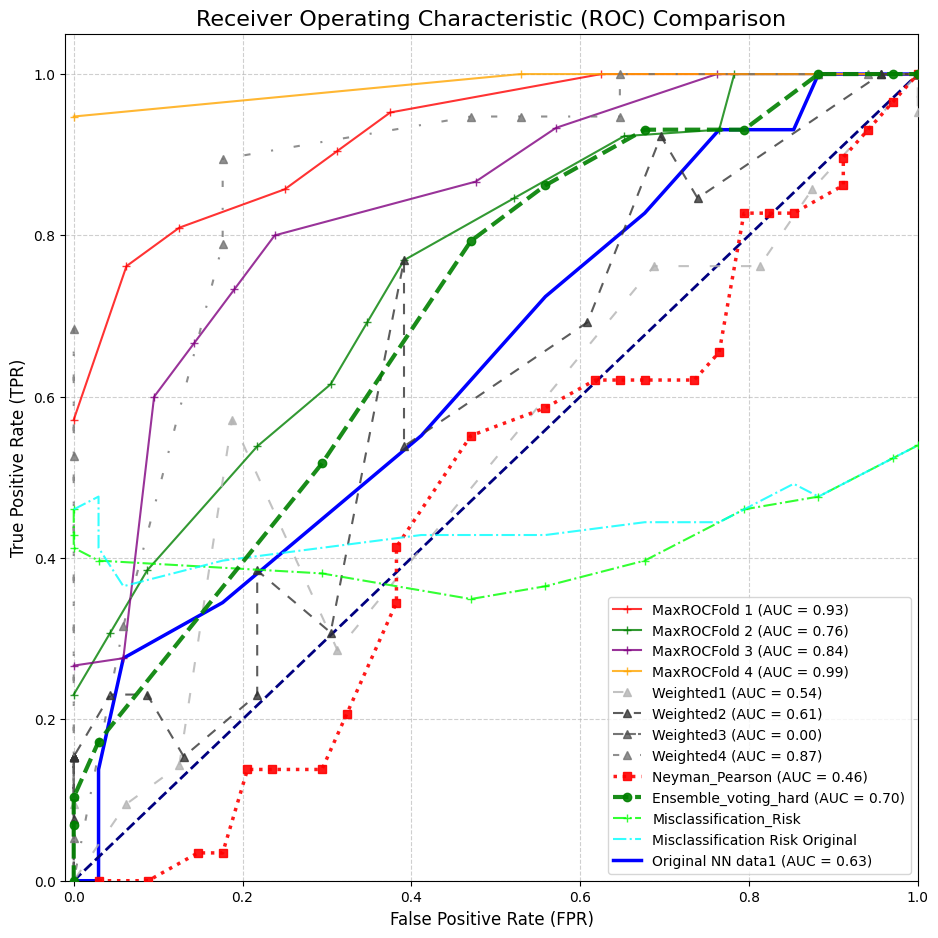

In [21]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)

# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="NN_weighted_sonar", prior_prob=prior_proba
)

## Bootstrap method

In [22]:
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint, TQDMProgressBar
import numpy as np
from sklearn.utils import resample

# --- Place any constants or unchanging objects outside the loop ---
pl.seed_everything(42, workers=True)
progress_bar = TQDMProgressBar(refresh_rate=10)

#store the weighted classifiers of all the folds
list_folds_weighted_clfs = []  # List to store classifiers from all folds
#store the best classfiers of all the folds
list_folds_best_models = []  # List to store best models from all folds

# --- Bootstrapping Setup ---
n_samples = len(train_data_tensor)
original_indices = np.arange(n_samples)
n_iterations = 4
# Dictionary to store the history of each fold
history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

# 3. K-fold cross-validation loop
for ii in range(n_iterations):
    list_weighted_clfs = []  # List to store the models trained at each stage
    best_clfs = []           # List to store the best models from each stage
    best_model_paths = []    # List to store the path of the best model from each stage
    print(f"--- Starting Iteration {ii + 1}/{n_iterations} ---")

    # 1. Create bootstrap train and validation (out-of-bag) samples
    # Sample with replacement to get training indices
    train_ids = resample(original_indices, replace=True, n_samples=n_samples, random_state=ii)
    # Get out-of-bag (OOB) indices for validation
    # Note: Using np.unique(train_ids) is crucial because sampling with replacement creates duplicates.
    # setdiff1d finds elements in original_indices that are NOT in the unique set of train_ids.
    val_ids = np.setdiff1d(original_indices, np.unique(train_ids))

    # 2. Instantiate the LightningModule
    model = LitClassifier(input_features=input_dim, hidden_units=hidden_units, learning_rate=LEARNING_RATE)

    # 3. Create datasets and dataloaders for the current iteration
    # Get the bootstrap training data by indexing the main tensor
    fold_train_features, fold_train_labels = train_data_tensor.tensors[0][train_ids], train_data_tensor.tensors[1][train_ids]
    fold_train_dataset = data.TensorDataset(fold_train_features, fold_train_labels)
    fold_train_loader = data.DataLoader(fold_train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)

    # Get the out-of-bag (OOB) validation data
    fold_val_features, fold_val_labels = train_data_tensor.tensors[0][val_ids], train_data_tensor.tensors[1][val_ids]
    fold_val_dataset = data.TensorDataset(fold_val_features, fold_val_labels)
    fold_loader = data.DataLoader(fold_val_dataset, batch_size=BATCH_SIZE, num_workers=NUM_WORKERS)


    for i, pos_weight in enumerate(pos_weights):
        
        model.criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor(pos_weight))  # Set the pos_weight for this stage
        checkpoint_callback = ModelCheckpoint(
            every_n_epochs=1,                # Save model every epoch
            dirpath=f'checkpoints/stage_{i+1}/fold_{ii+1}/',
            filename=f'best-model-fold{ii+1}-{{epoch:02d}}',
            save_top_k=1,
            mode='max',
        )
        
        # 3. Instantiate a NEW Trainer for this specific stage
        trainer = pl.Trainer(
            accelerator='gpu',
            devices=1,
            #strategy='ddp_notebook',
            max_epochs=NUM_EPOCHS, # Number of epochs for THIS stage
            callbacks=[checkpoint_callback, progress_bar],
            logger=pl.loggers.TensorBoardLogger("lightning_logs/", name=f"stage_{i+1}_fold_{ii+1}_ratio_{pos_weight}"),
            precision='16-mixed'
            )
        
        # 4. Train the model. It will start with weights from the previous stage.
        trainer.fit(model, train_dataloaders=fold_train_loader)
        
        # 5. Get the path to the best model from THIS stage and store it
        if checkpoint_callback.best_model_path:
            best_path_this_stage = checkpoint_callback.best_model_path
            print(f"--- Fold {ii+1} Stage {i+1} complete. Best model path: {best_path_this_stage} ---")
            best_model_paths.append(best_path_this_stage)
            
            # 6. CRITICAL: Load the best weights back into the model object
            # This ensures we carry forward the BEST model to the next stage, not the last.
            print(f"Loading best weights from {best_path_this_stage} to continue...")
            model = LitClassifier.load_from_checkpoint(best_path_this_stage, strict=False)  # Use strict=False to ignore missing keys if any
        else:
            print(f"--- Fold {ii+1} Stage {i+1} complete. No checkpoint was saved. ---")
            # If no checkpoint was saved, the model object will just have the weights from the last epoch.

        # 7. Test the model after each stage
        print(f"\n--- Testing model after Fold {ii+1} Stage {i+1} ---")
        trainer.test(model, dataloaders=fold_loader, ckpt_path=best_path_this_stage)
        results_classifier = model.last_test_results.copy()
        current_model = {
            "model": model,
            "fpr": results_classifier["fpr"],
            "tpr": results_classifier["tpr"],
            "threshold": results_classifier["threshold"],
            "full_roc": results_classifier["full_roc"]
        }
        list_weighted_clfs.append(current_model)
    best_clfs = get_best_roc_envelope(list_weighted_clfs, results_original_roc)
    list_folds_weighted_clfs.append(list_weighted_clfs.copy())
    list_folds_best_models.append(best_clfs.copy())




Seed set to 42


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

--- Starting Iteration 1/4 ---


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/loops/fit_loop.py:310: The number of training batches (3) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/core/saving.py:195: Found keys that are not in the model state dict but in the checkpoint: ['criterion.pos_weight']
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.5197
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.694415271282196
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5000
AUC: 0.5361
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6930753588676453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5600
AUC: 0.5369
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6915958523750305
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5690
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6901695132255554
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5878
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6887649297714233
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.5887
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6874340772628784
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6141
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.686005711555481
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6232
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6847028136253357
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6461
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.683348536491394
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6585
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6820725798606873
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6658
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6808493733406067
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6798
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6796215176582336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6782
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6785363554954529
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6880
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6775597929954529
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6938
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6766759753227234
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6962
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.675940990447998
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7036
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6752946376800537
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7110
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6748025417327881
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7135
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6744837164878845
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7159
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.674378514289856
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7167
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6744289994239807
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7159
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6748273968696594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7159
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6754594445228577
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7167
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6764082908630371
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7200
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6774271130561829
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7192
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6785226464271545
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7250
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6798420548439026
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7274
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6815873980522156
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7291
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6833558678627014
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7233
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6852304339408875
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7340
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6869574189186096
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7365
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6861684918403625
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7422
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6860491037368774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7430
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6848776340484619
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7488
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6831066608428955
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7529
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.681516170501709
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7545
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6797689199447632
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7619
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6780207753181458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7652
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.676135778427124
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7693
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6741794347763062
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7726
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6725080609321594
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

AUC: 0.7849
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6708037853240967
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7833
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6704643368721008
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7898
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6693224906921387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7882
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6683875322341919
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7931
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6676338315010071
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7841
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6666076183319092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7939
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6657689809799194
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7964
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6654423475265503
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v17.ckpt


--- Fold 1 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_1/best-model-fold1-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 1 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8046
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6652103662490845
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 51 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8186
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.665177583694458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 52 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8186
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6655784845352173
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 53 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8186
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6661396622657776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 54 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8235
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6668808460235596
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 55 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8194
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6683913469314575
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 56 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.8218
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6699004173278809
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 57 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.5800
AUC: 0.8210
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6719656586647034
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 58 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6200
AUC: 0.8153
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6742357015609741
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 59 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.6600
AUC: 0.8112
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6764216423034668
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 60 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7200
AUC: 0.8071
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.679821789264679
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 61 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6000
AUC: 0.7956
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6835001111030579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 62 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5200
AUC: 0.7635
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.687254011631012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 63 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4600
AUC: 0.7430
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6911765933036804
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 64 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7217
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6956331133842468
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 65 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.7044
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.700822114944458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 66 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6979
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7064931392669678
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 67 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6946
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7107694745063782
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 68 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6716
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7182772755622864
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 69 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6617
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7255051136016846
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 70 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6502
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7341442704200745
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 71 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5600
AUC: 0.6437
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7408424615859985
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 72 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6400
AUC: 0.6346
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.749052107334137
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 73 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5400
AUC: 0.6215
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7566035389900208
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 74 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5800
AUC: 0.6281
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7591774463653564
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 75 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.5993
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.770270586013794
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 76 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4800
AUC: 0.5829
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7790606617927551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 77 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4600
AUC: 0.5928
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7825974822044373
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 78 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5821
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7903522253036499
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 79 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5722
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7985628247261047
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 80 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4400
AUC: 0.5755
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8038477301597595
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 81 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5608
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8143860101699829
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 82 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5583
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8241046667098999
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 83 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5608
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8312770128250122
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 84 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5509
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8422279953956604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 85 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5493
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8521299958229065
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 86 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5378
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8620703816413879
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 87 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5435
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8671697974205017
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 88 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5172
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8809937238693237
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 89 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.5337
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8841354250907898
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 90 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4959
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9015023112297058
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 91 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4934
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.911080002784729
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 92 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4975
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9193218946456909
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 93 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4918
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.925808310508728
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 94 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4828
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9347230792045593
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 95 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4811
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9400865435600281
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 96 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4598
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9500133395195007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 97 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4598
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9500133395195007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 98 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4598
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9500133395195007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 99 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4598
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9500133395195007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v11.ckpt


--- Fold 1 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_1/best-model-fold1-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 1 Stage 100 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4200
AUC: 0.4598
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9500133395195007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

--- Starting Iteration 2/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5536
AUC: 0.4779
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6925877332687378
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4694
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6906983256340027
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4909
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.688914954662323
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4844
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6877511143684387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4915
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863791346549988
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4401
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6858425736427307
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.3867
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6855561137199402
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.3867
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6853617429733276
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4460
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6850503087043762
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4538
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6847032904624939
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4577
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6843658685684204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4453
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6840569376945496
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4466
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6837383508682251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4648
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6835051774978638
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.4844
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6831942200660706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.5013
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6828413605690002
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.5195
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6825863718986511
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.5345
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6824487447738647
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.5612
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6821677088737488
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.5775
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6819719076156616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.5951
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6816710233688354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6009
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6814494729042053
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6113
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6811373829841614
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6211
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6810925602912903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6289
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.680770218372345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6341
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6805939078330994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6458
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6801733374595642
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6543
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6796913743019104
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6680
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6793700456619263
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6660
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6791731119155884
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6719
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6782780289649963
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6816
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6785592436790466
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6895
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6770642995834351
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6940
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.67668217420578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.6953
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6765927672386169
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7116
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6756895184516907
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7168
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6734547019004822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7233
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6729225516319275
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7441
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6715208888053894
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7643
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6698387861251831
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.5714
AUC: 0.7650
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6695564389228821
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7806
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.667636513710022
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7865
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6667279005050659
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.7969
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.665073573589325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.8099
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6643291711807251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.8132
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6627858877182007
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.8190
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6618927121162415
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.8268
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6607106328010559
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5714
AUC: 0.8346
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6599772572517395
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v17.ckpt


--- Fold 2 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_2/best-model-fold2-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 2 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5893
AUC: 0.8327
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6593903303146362
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 51 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5893
AUC: 0.8438
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6591643691062927
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 52 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6429
AUC: 0.8490
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6587832570075989
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 53 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7143
AUC: 0.8574
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6595913767814636
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 54 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7679
AUC: 0.8594
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6606072187423706
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 55 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7679
AUC: 0.8633
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6618374586105347
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 56 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7857
AUC: 0.8685
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6638535261154175
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 57 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7143
AUC: 0.8678
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6647723317146301
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 58 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6429
AUC: 0.8678
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6675240397453308
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 59 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6071
AUC: 0.8626
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6700785756111145
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 60 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5357
AUC: 0.8568
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.673825204372406
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 61 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4821
AUC: 0.8522
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6757546663284302
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 62 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4643
AUC: 0.8477
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6814042925834656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 63 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4464
AUC: 0.8470
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6841242909431458
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 64 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4464
AUC: 0.8477
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6848710179328918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 65 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6607
AUC: 0.8398
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6922003030776978
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 66 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6786
AUC: 0.8333
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6956875920295715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 67 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7679
AUC: 0.8314
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7026292681694031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 68 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.7500
AUC: 0.8268
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7105717062950134
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 69 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7500
AUC: 0.8203
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7136767506599426
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 70 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.7500
AUC: 0.8249
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7224419713020325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 71 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6429
AUC: 0.8164
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.731768786907196
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 72 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.8073
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7401663661003113
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 73 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7982
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7512571215629578
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 74 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7988
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7586990594863892
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 75 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7943
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7698915600776672
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 76 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7897
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7818521857261658
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 77 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7884
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7966614365577698
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 78 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7878
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8084816336631775
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 79 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7826
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8251482248306274
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 80 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7826
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8390535712242126
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 81 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7780
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8536472916603088
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 82 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7747
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.87428218126297
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 83 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7741
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.8922551274299622
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 84 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7695
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9127071499824524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 85 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.4286
AUC: 0.7656
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9326742887496948
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 86 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7598
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9571801424026489
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 87 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7591
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.9758912920951843
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 88 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7520
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0077219009399414
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 89 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7533
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.018675684928894
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 90 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7461
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.050029993057251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 91 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7448
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.0687464475631714
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 92 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7324
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.095757007598877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 93 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7370
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1096482276916504
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 94 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7233
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1436151266098022
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 95 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7233
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1512807607650757
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 96 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7220
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           1.1679067611694336
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 97 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7233
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.171812653541565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 98 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7233
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.171812653541565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 99 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7233
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.171812653541565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v11.ckpt


--- Fold 2 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_2/best-model-fold2-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 2 Stage 100 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.4286
AUC: 0.7233
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            1.171812653541565
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- Starting Iteration 3/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.4501
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7124217748641968
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.4643
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7120010852813721
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5006
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7114469408988953
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5086
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.710902988910675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5271
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7103103995323181
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5579
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7097177505493164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5794
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7091125845909119
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5856
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7085009813308716
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5899
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7078927159309387
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5893
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7072679400444031
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5856
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7066395878791809
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5917
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7059557437896729
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5905
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.705277144908905
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5948
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7045851349830627
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5942
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7038801908493042
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5924
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7031647562980652
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5917
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7024405002593994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.5936
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7016730308532715
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6034
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7009173035621643
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6084
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7001625895500183
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6164
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6993991732597351
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6170
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6986218094825745
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6201
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6978228092193604
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6213
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6970604062080383
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6225
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6963276267051697
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6268
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6955687999725342
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6244
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6948427557945251
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6250
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6941090822219849
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6213
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6933951377868652
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6250
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6927341818809509
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6262
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6920661330223083
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6275
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6914685368537903
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6268
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6908823251724243
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5614
AUC: 0.6287
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903310418128967
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5439
AUC: 0.6256
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6898173093795776
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6140
AUC: 0.6318
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6893717050552368
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5789
AUC: 0.6355
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6889978647232056
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5965
AUC: 0.6361
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6886330246925354
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5789
AUC: 0.6410
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.688391387462616
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5614
AUC: 0.6441
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881933212280273
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5263
AUC: 0.6447
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881222724914551
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5263
AUC: 0.6478
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6880155801773071
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5263
AUC: 0.6496
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6880399584770203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6453
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881838440895081
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6484
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882387399673462
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6527
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6883392333984375
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6558
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882598400115967
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6539
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882970333099365
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6564
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882649064064026
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v17.ckpt


--- Fold 3 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_3/best-model-fold3-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 3 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6576
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.688352108001709
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 51 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6576
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6878975033760071
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 52 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6583
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6874073147773743
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 53 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6613
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6868668794631958
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 54 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.6589
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6864461898803711
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 55 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5263
AUC: 0.6619
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6860247850418091
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 56 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5263
AUC: 0.6644
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6857324838638306
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 57 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5439
AUC: 0.6656
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.685440182685852
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 58 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5439
AUC: 0.6638
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6853262782096863
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 59 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5789
AUC: 0.6724
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.68516606092453
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 60 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6316
AUC: 0.6749
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6851290464401245
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 61 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6491
AUC: 0.6773
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6851826906204224
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 62 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6316
AUC: 0.6786
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6853311061859131
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 63 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5789
AUC: 0.6835
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6855889558792114
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 64 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6316
AUC: 0.6872
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6859731078147888
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 65 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5965
AUC: 0.6890
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6863490343093872
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 66 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5263
AUC: 0.6952
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6869129538536072
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 67 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.5088
AUC: 0.7050
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6875206232070923
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 68 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7075
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6882115602493286
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 69 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7081
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6890947222709656
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 70 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7087
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6899919509887695
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 71 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7100
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6908708810806274
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 72 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7167
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.69187992811203
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 73 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7217
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6929848790168762
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 74 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7192
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6941357254981995
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 75 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7223
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6952999234199524
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 76 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7223
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6964952349662781
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 77 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7254
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6976432204246521
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 78 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7260
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6988574862480164
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 79 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7266
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7000343203544617
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 80 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7266
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7013599276542664
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 81 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7272
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7026786208152771
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 82 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7297
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7039451599121094
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 83 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7186
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7051293253898621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 84 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7149
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.70564204454422
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 85 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7272
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7055971026420593
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 86 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7272
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7058393359184265
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 87 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7284
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7067326307296753
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 88 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7291
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7068154215812683
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 89 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7149
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7074074149131775
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 90 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7371
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7072455286979675
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 91 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7284
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7074971795082092
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 92 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7377
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7073888778686523
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 93 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7432
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7075599431991577
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 94 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7241
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7081640362739563
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 95 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7217
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083856463432312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 96 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7217
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083856463432312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 97 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7217
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083856463432312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 98 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7217
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083856463432312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 99 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7217
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083856463432312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v11.ckpt


--- Fold 3 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_3/best-model-fold3-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 3 Stage 100 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.5088
AUC: 0.7217
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7083856463432312
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
--- Starting Iteration 4/4 ---


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 1 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_1/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 1 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5611
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6929049491882324
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 2 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_2/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 2 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5501
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6926657557487488
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 3 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_3/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 3 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5530
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6923737525939941
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 4 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_4/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 4 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5645
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.692125678062439
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 5 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_5/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 5 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5778
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6918233036994934
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 6 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_6/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 6 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5824
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6915909647941589
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 7 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_7/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 7 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5968
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.691448450088501
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 8 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_8/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 8 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5783
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6914459466934204
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 9 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_9/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 9 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6037
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912673711776733
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 10 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_10/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 10 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5956
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6914055943489075
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 11 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_11/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 11 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5956
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6914736032485962
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 12 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_12/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 12 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5651
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6915580630302429
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 13 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_13/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 13 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6123
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6913126111030579
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 14 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_14/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 14 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5806
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6915406584739685
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 15 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_15/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 15 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5968
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6914224028587341
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 16 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_16/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 16 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5979
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912819743156433
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 17 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_17/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 17 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5979
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912683844566345
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 18 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_18/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 18 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6141
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912059187889099
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 19 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_19/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 19 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5979
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912383437156677
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 20 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_20/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 20 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6158
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6911435723304749
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 21 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_21/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 21 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6146
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6912083029747009
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 22 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_22/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 22 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6014
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.690908670425415
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 23 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_23/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 23 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5979
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6911908388137817
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 24 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_24/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 24 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs



--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6014
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6909167766571045
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 25 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_25/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 25 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6135
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6910918354988098
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 26 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_26/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 26 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5916
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6907986998558044
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 27 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_27/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 27 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5979
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6910794377326965
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 28 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_28/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 28 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6025
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6908217072486877
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 29 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_29/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 29 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.5899
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6908655166625977
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 30 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_30/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 30 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6394
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6906240582466125
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 31 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_31/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 31 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6480
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6906952261924744
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 32 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_32/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 32 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6429
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6905667185783386
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 33 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_33/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 33 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6647
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6906189322471619
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 34 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_34/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 34 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6590
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.690537691116333
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 35 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_35/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 35 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6717
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6905108690261841
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 36 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_36/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 36 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6325
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6904007196426392
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 37 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_37/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 37 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6250
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903409361839294
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 38 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_38/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 38 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6446
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903894543647766
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 39 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_39/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 39 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6480
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6901801824569702
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 40 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_40/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 40 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6250
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6903260350227356
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 41 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_41/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 41 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6480
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.690230131149292
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 42 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_42/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 42 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.4746
AUC: 0.6480
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6902101039886475
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 43 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_43/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 43 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6348
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6902821660041809
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 44 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_44/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 44 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6757
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6899945735931396
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 45 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_45/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 45 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6480
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6900845766067505
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 46 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_46/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 46 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6613
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6897687911987305
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 47 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_47/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 47 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.6480
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6899787783622742
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 48 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_48/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 48 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.4746
AUC: 0.6803
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6895633339881897
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 49 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_49/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 49 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.4746
AUC: 0.6843
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6895136833190918
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v17.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v17.ckpt


--- Fold 4 Stage 50 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v17.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_50/fold_4/best-model-fold4-epoch=00-v17.ckpt to continue...

--- Testing model after Fold 4 Stage 50 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7304
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6890615820884705
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 51 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_51/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 51 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7177
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6890687346458435
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 52 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_52/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 52 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7379
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.688618004322052
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 53 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_53/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 53 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7488
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6883988380432129
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 54 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_54/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 54 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7506
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6881206035614014
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 55 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_55/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 55 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7586
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6871728301048279
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 56 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_56/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 56 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7569
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6873047351837158
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 57 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_57/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 57 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6610
AUC: 0.7615
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6867117881774902
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 58 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_58/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 58 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6441
AUC: 0.7586
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6864094138145447
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 59 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_59/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 59 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6441
AUC: 0.7661
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6860247850418091
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 60 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_60/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 60 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6271
AUC: 0.7667
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6851293444633484
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 61 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_61/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 61 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6271
AUC: 0.7730
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6842180490493774
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 62 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_62/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 62 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6441
AUC: 0.7753
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6835600137710571
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 63 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_63/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 63 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6271
AUC: 0.7811
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6827293038368225
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 64 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_64/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 64 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6441
AUC: 0.7874
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.68255215883255
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 65 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_65/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 65 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6271
AUC: 0.7874
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6821343302726746
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 66 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_66/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 66 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5932
AUC: 0.7938
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6813019514083862
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 67 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_67/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 67 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5763
AUC: 0.7972
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6806939244270325
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 68 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_68/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 68 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5424
AUC: 0.8030
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6800309419631958
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 69 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_69/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 69 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8041
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6795399188995361
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 70 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_70/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 70 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8030
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6789977550506592
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 71 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_71/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 71 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8030
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6785675287246704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 72 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_72/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 72 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8059
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6783050298690796
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 73 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_73/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 73 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8053
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.678289532661438
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 74 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_74/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 74 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8059
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6785292625427246
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 75 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_75/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 75 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8070
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6789029240608215
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 76 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_76/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 76 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8111
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6795797944068909
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 77 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_77/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 77 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8099
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6801182627677917
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 78 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_78/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 78 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8099
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.680797278881073
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 79 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_79/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 79 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.8076
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6820076107978821
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 80 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_80/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 80 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Accuracy: 0.4746
AUC: 0.8030
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6834200620651245
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 81 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_81/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 81 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7995
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.68477863073349
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 82 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_82/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 82 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7955
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6867087483406067
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 83 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_83/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 83 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.4746
AUC: 0.7857
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6885446906089783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 84 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_84/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 84 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5254
AUC: 0.7730
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6905943155288696
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 85 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_85/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 85 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5424
AUC: 0.7684
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6927962303161621
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 86 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_86/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 86 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5763
AUC: 0.7679
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6940271258354187
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 87 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_87/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 87 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6271
AUC: 0.7609
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6963870525360107
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 88 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_88/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 88 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]



--- Final Classifier Test Metrics ---
Accuracy: 0.6780
AUC: 0.7465
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.6990399360656738
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────



  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimated model params size (MB)
11        Modules in train mode
0         Modules in eval mode


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 89 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_89/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 89 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6780
AUC: 0.7402
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7003961205482483
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 90 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_90/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 90 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6610
AUC: 0.7437
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.701887845993042
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 91 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_91/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 91 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6102
AUC: 0.7287
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7040476202964783
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 92 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_92/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 92 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.6102
AUC: 0.7252
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7062029838562012
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 93 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_93/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 93 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5932
AUC: 0.7189
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7084754109382629
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 94 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_94/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 94 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.6102
AUC: 0.7172
-------------------------------------



Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7095421552658081
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 95 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_95/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 95 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5932
AUC: 0.7103
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss            0.710938036441803
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 96 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_96/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 96 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate


--- Final Classifier Test Metrics ---
Accuracy: 0.5763
AUC: 0.7143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7116587162017822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 97 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_97/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 97 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5763
AUC: 0.7143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7116587162017822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 98 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_98/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 98 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5763
AUC: 0.7143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7116587162017822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimate

Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 99 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_99/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 99 ---


Testing: |          | 0/? [00:00<?, ?it/s]

Using 16bit Automatic Mixed Precision (AMP)
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/katzkid/miniforge3/envs/MLlabs/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4 exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name           | Type              | Params | Mode 
-------------------------------------------------------------
0 | model          | MLP               | 529    | train
1 | criterion      | BCEWithLogitsLoss | 0      | train
2 | train_accuracy | BinaryAccuracy    | 0      | train
3 | test_accuracy  | BinaryAccuracy    | 0      | train
4 | test_auc       | BinaryAUROC       | 0      | train
-------------------------------------------------------------
529       Trainable params
0         Non-trainable params
529       Total params
0.002     Total estimat


--- Final Classifier Test Metrics ---
Accuracy: 0.5763
AUC: 0.7143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7116587162017822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=1` reached.
Restoring states from the checkpoint path at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v11.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
Loaded model weights from the checkpoint at /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v11.ckpt


--- Fold 4 Stage 100 complete. Best model path: /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v11.ckpt ---
Loading best weights from /home/katzkid/Documents/RoC_Analysis/checkpoints/stage_100/fold_4/best-model-fold4-epoch=00-v11.ckpt to continue...

--- Testing model after Fold 4 Stage 100 ---


Testing: |          | 0/? [00:00<?, ?it/s]


--- Final Classifier Test Metrics ---
Accuracy: 0.5763
AUC: 0.7143
-------------------------------------

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_loss           0.7116587162017822
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


In [23]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Save the data
save_to_pickle(list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader, filename='pickle/NN_sonar_weighted_bootstrap.pkl')





Data saved to pickle/NN_sonar_weighted_bootstrap.pkl


{'best_models': [[{'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=60, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=4, bias=True)
          (3): ReLU()
          (4): Linear(in_features=4, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accuracy): BinaryAccuracy()
      (test_accuracy): BinaryAccuracy()
      (test_auc): BinaryAUROC()
    ),
    'fpr': np.float32(0.0),
    'tpr': np.float32(0.42857143),
    'threshold': np.float16(0.428)},
   {'model': LitClassifier(
      (model): MLP(
        (network): Sequential(
          (0): Linear(in_features=60, out_features=8, bias=True)
          (1): ReLU()
          (2): Linear(in_features=8, out_features=4, bias=True)
          (3): ReLU()
          (4): Linear(in_features=4, out_features=1, bias=True)
        )
      )
      (criterion): BCEWithLogitsLoss()
      (train_accura

In [24]:
from predict_ensemble_and_evaluate import save_to_pickle, load_from_pickle
from predict_ensemble_and_evaluate import predict_ensemble_and_evaluate
from predict_ensemble_and_evaluate import plot_roc_comparison
from predict_ensemble_and_evaluate import make_curve_monotonic

# Load the data
list_folds_best_models, list_folds_weighted_clfs, results_original_roc, test_loader = load_from_pickle(filename='pickle/NN_sonar_weighted_bootstrap.pkl')

Data loaded successfully.


In [25]:
import numpy as np

# --- Loop through all the FPR values to generate the ensemble ROC curve ---



results_tuple, prior_proba = predict_ensemble_and_evaluate(list_folds_best_models=list_folds_best_models,
    test_loader=test_loader)

ensemble_results_soft = results_tuple['soft_voting']
ensemble_results_hard = results_tuple['hard_voting']
misclassification_risk = results_tuple['misclassification_risk']






Creating a single ensemble from 46 models across all folds.
Extracting full dataset...
Getting predictions from all models...



--- Plotting all ROC curves for comparison ---


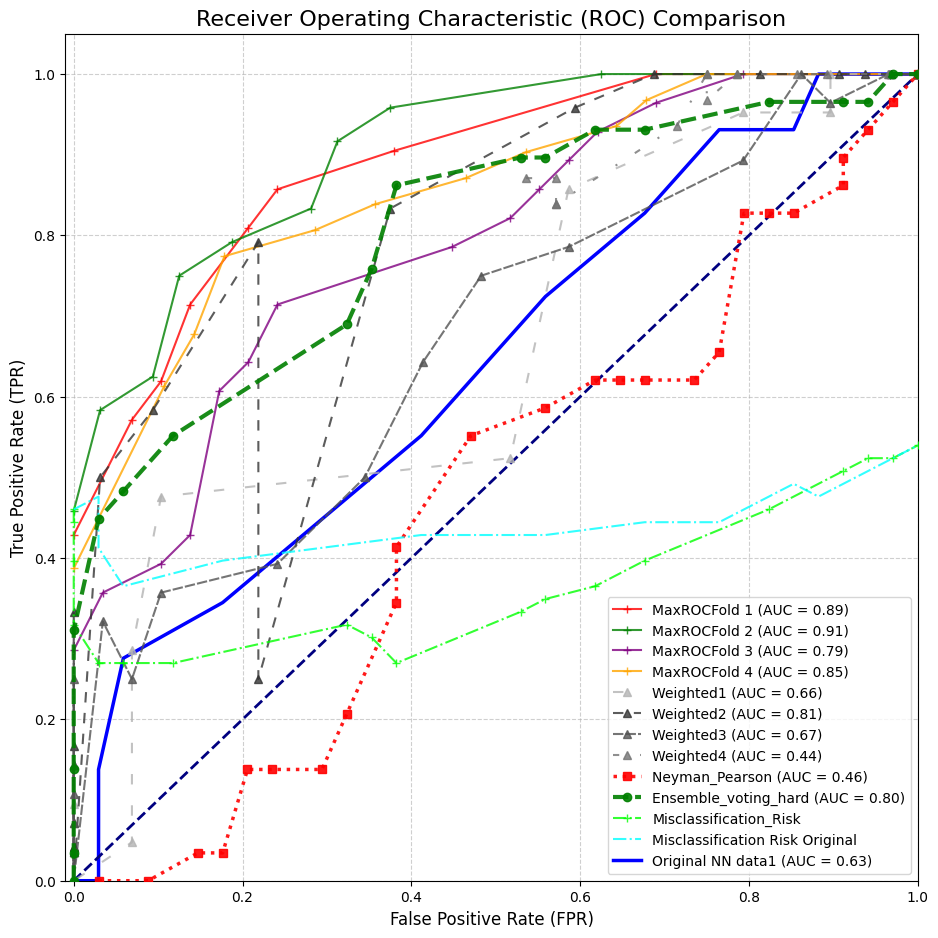

In [26]:

# plot the best classifiers of all folds
results_lists = []
results_lists.extend(list_folds_best_models)
results_lists.extend(list_folds_weighted_clfs)
results_lists.append(constrained_points)
results_lists.append(ensemble_results_hard)
results_lists.append(misclassification_risk)


# --- Plot the final comparison ---
print("\n--- Plotting all ROC curves for comparison ---")
plot_roc_comparison(
    results_lists=results_lists,
    names=["MaxROCFold 1", "MaxROCFold 2", "MaxROCFold 3", "MaxROCFold 4", "Weighted1", "Weighted2", "Weighted3", "Weighted4", "Neyman_Pearson", "Ensemble_voting_hard", "Misclassification_Risk"],
    results_original_roc=results_original_roc, plot_name="NN_weighted_sonar_bootstrap", prior_prob=prior_proba
)

### NOTES
* CV - Traiining data is large, stable, overlapping data partitions. Stable performance, good for estimating model accuracy.
* Bootstrap - More random samples with replacement. Diverse models, good for building an ensemble that generalizes well.